# Inpainting missing data

Missing data in an image can be an issue, especially when one wants to perform Fourier analysis.
This tutorial explains how to fill-up missing pixels with values which looks "realistic" and introduce as little perturbation as possible for subsequent analysis.
The user should keep the mask nearby and only consider the values of actual pixels and never the one inpainted.

This tutorial will use fully synthetic data to allow comparison between actual (syntetic) data with inpainted values.

The first part of the tutorial is about the generation of a challenging 2D diffraction image with realistic noise and to describe the metric used, then comes the actual tutorial on how to use the inpainting. Finally a benchmark is used based on the metric determined.

## Creation of the image

A realistic challenging image should contain:

* Bragg peak rings. We chose LaB6 as guinea-pig, with very sharp peaks, at the limit of the resolution of the detector
* Some amorphous content
* strong polarization effect
* Poissonian noise


One image will be generated but then multiple ones with different noise to discriminate the effect of the noise from other effects.

In [1]:
%matplotlib inline
from matplotlib.pyplot import subplots
import numpy

In [2]:
import pyFAI
print("Using pyFAI version: ", pyFAI.version)
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.gui import jupyter
import pyFAI.test.utilstest
from pyFAI.calibrant import get_calibrant
import time
start_time = time.perf_counter()

Using pyFAI version:  0.20.0-beta1


In [3]:
detector = pyFAI.detector_factory("Pilatus2MCdTe")
mask = detector.mask.copy()
nomask = numpy.zeros_like(mask)
detector.mask=nomask
ai = AzimuthalIntegrator(detector=detector)
ai.setFit2D(200, 200, 200)
ai.wavelength = 3e-11
print(ai)

Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 3.000000e-11m
SampleDetDist= 2.000000e-01m	PONI= 3.440000e-02, 3.440000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 200.000mm	Center: x=200.000, y=200.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


LaB6 Calibrant with 640 reflections at wavelength 3e-11


<AxesSubplot:title={'center':'Without mask'}>

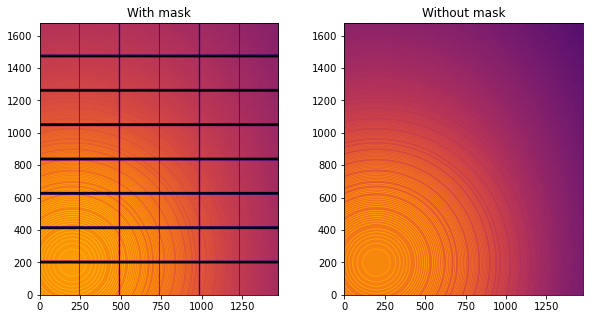

In [4]:
LaB6 = get_calibrant("LaB6")
LaB6.wavelength = ai.wavelength
print(LaB6)
r = ai.array_from_unit(unit="q_nm^-1")
decay_b = numpy.exp(-(r-50)**2/2000)
bragg = LaB6.fake_calibration_image(ai, Imax=1e4, W=1e-6) * ai.polarization(factor=1.0) * decay_b
decay_a = numpy.exp(-r/100)
amorphous = 1000*ai.polarization(factor=1.0)*ai.solidAngleArray() * decay_a
img_nomask = bragg + amorphous
#Not the same noise function for all images two images
img_nomask = numpy.random.poisson(img_nomask)
img_nomask2 = numpy.random.poisson(img_nomask)
img = numpy.random.poisson(img_nomask)
img[numpy.where(mask)] = -1
fig,ax = subplots(1,2, figsize=(10,5))
jupyter.display(img=img, label="With mask", ax=ax[0])
jupyter.display(img=img_nomask, label="Without mask", ax=ax[1])

Note the aliassing effect on the displayed images.

We will measure now the effect after 1D intergeration. We do not correct for polarization on purpose to highlight the defect one wishes to whipe out. We use a R-factor to describe the quality of the 1D-integrated signal. 

Between masked and non masked image R= 5.67619048065858
Between two different non-masked images R'= 0.41080914159883125


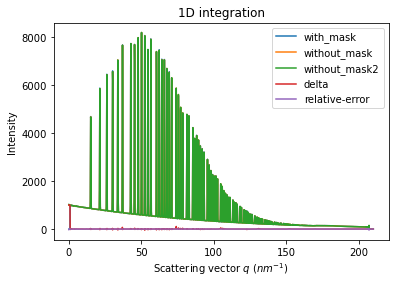

In [5]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo2 = ai.integrate1d(img_nomask2, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wm = ai.integrate1d(img, 2000, unit="q_nm^-1", method="splitpixel", mask=mask, radial_range=(0,210))
ax = jupyter.plot1d(wm , label="with_mask")
ax.plot(*wo, label="without_mask")
ax.plot(*wo2, label="without_mask2")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.plot(wo.radial, wo.intensity-wo2.intensity, label="relative-error")
ax.legend()
print("Between masked and non masked image R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))
print("Between two different non-masked images R'= %s"%pyFAI.utils.mathutil.rwp(wo2,wo))

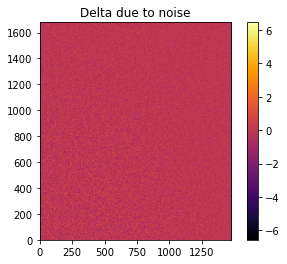

In [6]:
# Effect of the noise on the delta image
fig, ax = subplots()
jupyter.display(img=img_nomask-img_nomask2, label="Delta due to noise", ax=ax)
ax.figure.colorbar(ax.images[0])

## Inpainting

This part describes how to paint the missing pixels for having a "natural-looking image". The delta image contains the difference with the original image

  File "/usr/lib/python3/dist-packages/pyFAI/azimuthalIntegrator.py", line 3337, in inpainting
    imgb = self.integrate2d(blank_data, **kwargs)
  File "/usr/lib/python3/dist-packages/pyFAI/azimuthalIntegrator.py", line 3338, in inpainting
    imgp = self.integrate2d(masked, **kwargs)
  File "/usr/lib/python3/dist-packages/pyFAI/azimuthalIntegrator.py", line 3339, in inpainting
    imgd = self.integrate2d(masked_data, **kwargs)


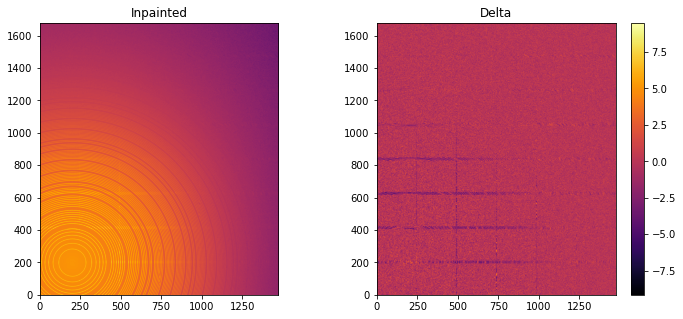

In [7]:
#Inpainting:
inpainted = ai.inpainting(img, mask=mask, poissonian=True)
fig, ax = subplots(1, 2, figsize=(12,5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])

R= 1.300831240300783


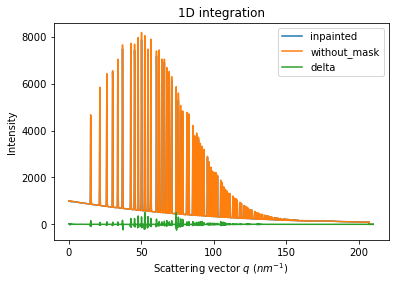

In [8]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))

One can see by zooming in that the main effect on inpainting is a broadening of the signal in the inpainted region. This could (partially) be adressed by increasing the number of radial bins used in the inpainting.

## Benchmarking and optimization of the parameters

The parameter set depends on the detector, the experiment geometry and the type of signal on the detector. Finer detail require finer slicing.

In [9]:
#Basic benchmarking of execution time for default options:
%timeit inpainted = ai.inpainting(img, mask=mask)

567 ms ± 6.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
for m in (("no", "histogram", "cython"), ("bbox", "histogram","cython")):
    for k in (512, 1024, 2048, 4096):
        ai.reset()
        for i in (0, 1, 2, 4, 8):
            inpainted = ai.inpainting(img, mask=mask, poissonian=True, method=m, npt_rad=k, grow_mask=i)
            wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
            print(f"method: {m} npt_rad={k} grow={i}; R= {pyFAI.utils.mathutil.rwp(wm,wo)}")

method: ('no', 'histogram', 'cython') npt_rad=512 grow=0; R= 5.783646212437001
method: ('no', 'histogram', 'cython') npt_rad=512 grow=1; R= 4.237428507810049
method: ('no', 'histogram', 'cython') npt_rad=512 grow=2; R= 3.3029688910321684
method: ('no', 'histogram', 'cython') npt_rad=512 grow=4; R= 2.7783385810118992
method: ('no', 'histogram', 'cython') npt_rad=512 grow=8; R= 2.6306022206436506
method: ('no', 'histogram', 'cython') npt_rad=1024 grow=0; R= 6.719261987025427
method: ('no', 'histogram', 'cython') npt_rad=1024 grow=1; R= 4.486684252027234
method: ('no', 'histogram', 'cython') npt_rad=1024 grow=2; R= 3.4706413367375366
method: ('no', 'histogram', 'cython') npt_rad=1024 grow=4; R= 2.40560101308961
method: ('no', 'histogram', 'cython') npt_rad=1024 grow=8; R= 1.9210807002114292
method: ('no', 'histogram', 'cython') npt_rad=2048 grow=0; R= 6.920722622332915
method: ('no', 'histogram', 'cython') npt_rad=2048 grow=1; R= 5.168512546847185
method: ('no', 'histogram', 'cython') npt

CPU times: user 2.47 s, sys: 46.4 ms, total: 2.51 s
Wall time: 1.17 s


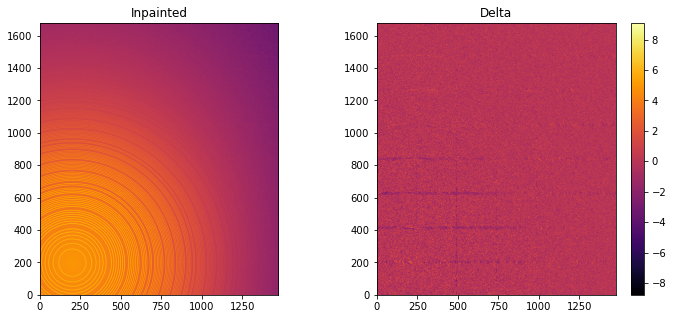

In [11]:
#Inpainting, best solution found:
ai.reset()
%time inpainted = ai.inpainting(img, mask=mask, poissonian=True, method=("pseudo", "csr", "cython"), npt_rad=4096, grow_mask=1)
fig, ax = subplots(1, 2, figsize=(12, 5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])
pass

R= 0.44490495766953164


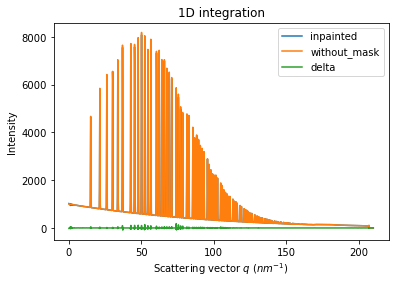

In [12]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))

## Conclusion

Inpainting is one of the only solution to fill up the gaps in detector when Fourier analysis is needed. 
This tutorial explains basically how this is possible using the pyFAI library and how to optimize the parameter set for inpainting. The result may greatly vary with detector position and tilt and the kind of signal (amorphous or more spotty).

In [13]:
print(f"Execution time: {time.perf_counter()-start_time:.3f} s")

Execution time: 58.908 s
